# URL Phishing Detector - Deep Learning

## Prerequisite

### Install Dependencies

In [1]:
!pip install tensorflow tensorflowjs pandas scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub
import shutil
import re
from urllib.parse import urlparse
import ipaddress
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import glob

## Utils

### URL Feature Extractor

In [ ]:
class UrlFeaturesExtractor:
    SHORTENING_SERVICES = {
        "bit.ly", "tinyurl.com", "goo.gl", "ow.ly", "t.co", "is.gd", "bitly.com",
        "vzturl.com", "qr.net", "1url.com", "tweez.me", "v.gd", "tr.im", "link.zip.net",
        "filoops.info"
    }

    SUSPICIOUS_WORDS = {
        "login", "verify", "account", "password", "bank", "secure",
        "free", "lucky", "service", "bonus", "ebayisapi", "webscr",
        "paypal", "signin", "update"
    }

    UNCOMMON_TLDS = {'.tk', '.ml', '.ga', '.cf', '.gq'}

    BRANDS = {
        'paypal', 'visa', 'mastercard', 'stripe', 'square', 'bankofamerica',
        'google', 'gmail', 'youtube', 'android', 'chrome', 'facebook',
        'instagram', 'whatsapp', 'meta', 'apple', 'icloud', 'mac', 'itunes',
        'amazon', 'aws', 'microsoft', 'office365', 'outlook', 'live', 'onedrive',
        'windows', 'github', 'gitlab', 'bitbucket', 'dropbox',
        'twitter', 'x.com', 'tiktok', 'snapchat', 'linkedin', 'slack', 'zoom',
        'netflix', 'hulu', 'disney', 'spotify', 'steam', 'epicgames',
        'ebay', 'etsy', 'shopify', 'alibaba', 'yahoo', 'proton', 'adobe'
    }

    PUBLIC_SUFFIXES = {
        'co.uk', 'ac.uk', 'gov.uk', 'org.uk',
        'co.il', 'org.il', 'ac.il', 'gov.il',
        'co.in', 'org.in', 'ac.in', 'gov.in',
        'com.au', 'gov.au', 'edu.au',
        'com.cn', 'gov.cn', 'edu.cn', 'net.cn',
        'co.za', 'org.za', 'gov.za'
    }

    def __init__(self, url: str):
        self.url = url
        self.parsed = urlparse(url if url.startswith("http") else "http://" + url)

    def get_length(self) -> int:
        return len(self.url)

    def subdomain_length(self) -> int:
        """
        Returns the total length of all domain components in the hostname,
        excluding 'www' at the beginning and the top-level domain at the end.
        E.g., 'www.login.secure.example.com' → 'login', 'secure', 'example' → summed length.
        """
        if self.has_ip_address():
            return 0

        hostname = (self.parsed.hostname or '').lower()
        parts = hostname.split('.')

        if parts and parts[0] == 'www':
            parts = parts[1:]

        if len(parts) < 1:
            return 0

        domain_parts = parts[:-1]

        return sum(len(part) for part in domain_parts)

    def main_domain_length(self) -> int:
        """
        Returns the character length of the main domain (SLD),
        accounting for multi-part public suffixes (like 'co.uk', 'co.il').
        """
        hostname = (self.parsed.hostname or '').lower()
        parts = hostname.split('.')

        if parts and parts[0] == 'www':
            parts = parts[1:]

        domain_index = len(parts) - 2
        for i in range(len(parts) - 1):
            possible_suffix = ".".join(parts[i:])
            if possible_suffix in self.PUBLIC_SUFFIXES:
                domain_index = i - 1
                break

        if domain_index >= 0:
            return len(parts[domain_index])
        return 0


    def dot_count(self) -> int:
        return self.url.count('.')

    def hyphen_count(self) -> int:
        return self.url.count('-')

    def path_length(self) -> int:
        return len(self.parsed.path)

    def is_https(self) -> int:
        return int(self.url.startswith('https://'))

    def query_length(self) -> int:
        return len(self.parsed.query)

    def has_redirection(self) -> int:
        stripped_url = self.url.replace('http://', '').replace('https://', '', 1)
        return int('//' in stripped_url)

    def url_path_depth(self) -> int:
        return sum(1 for part in self.parsed.path.split('/') if part)

    def digit_count(self) -> int:
        return sum(char.isdigit() for char in self.url)

    def token_count(self) -> int:
        tokens = re.split(r'[\/\-\.\=\?\&\%\_\@]', self.url)
        return len([t for t in tokens if t])

    def encoded_char_count(self) -> int:
        return self.url.count('%')

    def has_ip_address(self) -> int:
        try:
            ipaddress.ip_address(self.parsed.hostname)
            return 1
        except (ValueError, TypeError):
            return 0

    def subdomain_count(self) -> int:
        if not self.parsed.hostname or self.has_ip_address():
            return 0
        return max(0, len(self.parsed.hostname.split('.')) - 2)

    def uncommon_tld(self) -> int:
        if not self.parsed.hostname:
            return 0
        return int(any(self.parsed.hostname.endswith(tld) for tld in self.UNCOMMON_TLDS))

    def has_shortening_service(self) -> int:
        if not self.parsed.hostname:
            return 0
        host = self.parsed.hostname.lower()
        return int(host in self.SHORTENING_SERVICES or any(host.endswith('.' + svc) for svc in self.SHORTENING_SERVICES))

    def has_suspicious_words(self) -> int:
        return int(any(word in self.url.lower() for word in self.SUSPICIOUS_WORDS))

    def contains_brand_name(self) -> int:
        hostname = (self.parsed.hostname or '').lower()
        parts = hostname.split('.')
        if len(parts) >= 2:
            sld = parts[-2]
            return int(sld in self.BRANDS)
        return 0

    def extract_all(self) -> list[float]:
        features = [
            self.get_length(),
            self.subdomain_length(),
            self.main_domain_length(),
            self.dot_count(),
            self.hyphen_count(),
            self.path_length(),
            self.is_https(),
            # self.query_length(),
            # self.has_redirection(),
            self.url_path_depth(),
            self.digit_count(),
            self.token_count(),
            self.encoded_char_count(),
            self.has_shortening_service(),
            # self.has_ip_address(),
            self.subdomain_count(),
            self.uncommon_tld(),
            self.has_suspicious_words(),
            self.contains_brand_name(),
        ]
        return [float(f) for f in features]


# Data Processing

In [ ]:
def build_dataset(df):
    X = np.array([UrlFeaturesExtractor(url).extract_all() for url in df['url']])
    y = df['status'].values.astype('int64')
    return X, y

## Dataset Preprocessing

## Loading

In [ ]:
from pathlib import Path

data_dir = Path('/content/urls_without_dns')
all_parts = [data_dir / f'part-{i:05d}.parquet' for i in range(0, 35)]

files = [p for p in all_parts if p.exists()]

df_data = pd.concat((pd.read_parquet(f) for f in files), ignore_index=True)

print(f"Found {len(files)} parts → combined df has {df_data.shape[0]} rows × {df_data.shape[1]} cols")
df_data.head()

Found 35 parts → combined df has 10400000 rows × 3 cols


,url,label,first_seen
0,http://babearchives.com,benign,2019-02-11 22:52:00
1,http://timeline.antunes.dev,benign,2021-09-29 14:54:27
2,http://3md6bdtvo62lvedxjxiu7f2jkzbwab.1qw2es2z...,phishing,2022-08-07 07:30:11
3,https://www36.55.56.89.30.50.26.92.68.80.36.64...,phishing,2021-11-20 16:51:02
4,http://271h0ir.xcoysf.cn/adidas-me/css,phishing,2021-07-01 13:44:19


In [ ]:
df_data.loc[df_data["label"] == "benign", "status"] = 0
df_data.loc[df_data["label"] == "phishing", "status"] = 1
df_data = df_data[df_data["status"].isin([0, 1])]

## Processing

## Build Dataset

In [ ]:
df_data = df_data.drop_duplicates(subset=['url'])
X, y = build_dataset(df_data)

X.shape, y.shape

((9265925, 16), (9265925,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7412740, 16)
y_train shape: (7412740,)
X_test shape: (1853185, 16)
y_test shape: (1853185,)


### Correlation

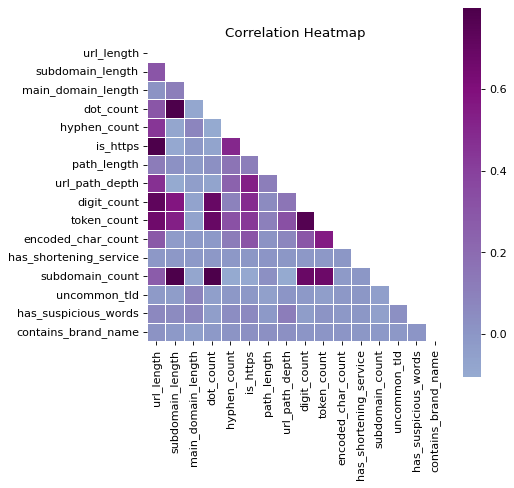

In [ ]:
fig = plt.figure(figsize=(6,6), dpi=80)
corr_df = pd.DataFrame(X_train)

corr_df.columns = [
    'url_length',
    'subdomain_length',
    'main_domain_length',
    'dot_count',
    'hyphen_count',
    'is_https',
    'path_length',
    'url_path_depth',
    'digit_count',
    'token_count',
    'encoded_char_count',
    'has_shortening_service',
    'subdomain_count',
    'uncommon_tld',
    'has_suspicious_words',
    'contains_brand_name'
]

corr_matrix = corr_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='BuPu', robust=True, center=0,
            square=True, linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


## Model

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train)

model = tf.keras.Sequential([
       tf.keras.layers.Input(shape=(X_train.shape[1],)),
      normalizer,
       tf.keras.layers.Dense(64, activation='relu'),
       tf.keras.layers.Dense(32, activation='relu'),
       tf.keras.layers.Dense(1, activation='sigmoid')
   ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 16)             │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,234 (12.64 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 33 (136.00 B)

## Train

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=500)

Epoch 1/25
14826/14826 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.8941 - loss: 0.2631 - val_accuracy: 0.9045 - val_loss: 0.2384
Epoch 2/25
14826/14826 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.9048 - loss: 0.2365 - val_accuracy: 0.9072 - val_loss: 0.2312
Epoch 3/25
14826/14826 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.9071 - loss: 0.2309 - val_accuracy: 0.9079 - val_loss: 0.2290
Epoch 4/25
14826/14826 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.9082 - loss: 0.2279 - val_accuracy: 0.9087 - val_loss: 0.2272
Epoch 5/25
14826/14826 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - accuracy: 0.9092 - loss: 0.2260 - val_accuracy: 0.9105 - val_loss: 0.2243
Epoch 6/25
14826/14826 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.9101 - loss: 0.2241 - val_accuracy: 0.9103 - val_loss: 0.2233
Epoch 7/25
14826/14826 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - accuracy: 0.9107 - loss: 0.2228 - val_accuracy: 0.9113 - val_loss: 0.2223
Epoch 8/25
14826/14826 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 

## Evaluation

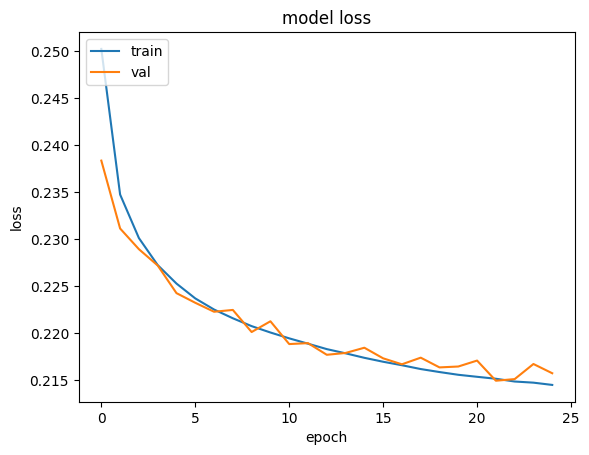

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

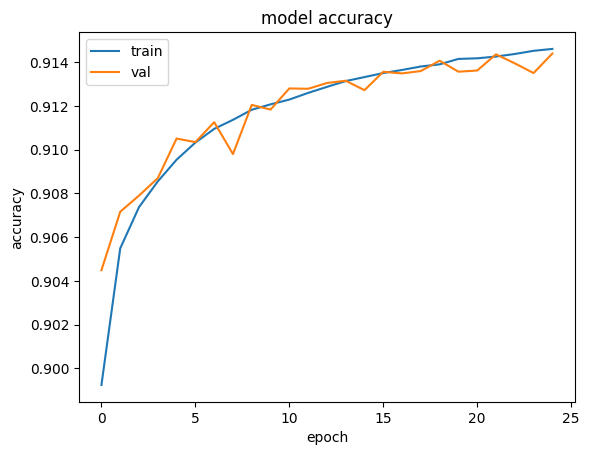

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.33).astype(int)
print(classification_report(y_test, y_pred))

57913/57913 ━━━━━━━━━━━━━━━━━━━━ 75s 1ms/step
              precision    recall  f1-score   support

           0       0.93      0.92      0.93   1201397
           1       0.86      0.87      0.87    651788

    accuracy                           0.91   1853185
   macro avg       0.90      0.90      0.90   1853185
weighted avg       0.91      0.91      0.91   1853185



289561/289561 ━━━━━━━━━━━━━━━━━━━━ 377s 1ms/step
Best threshold: 0.3268


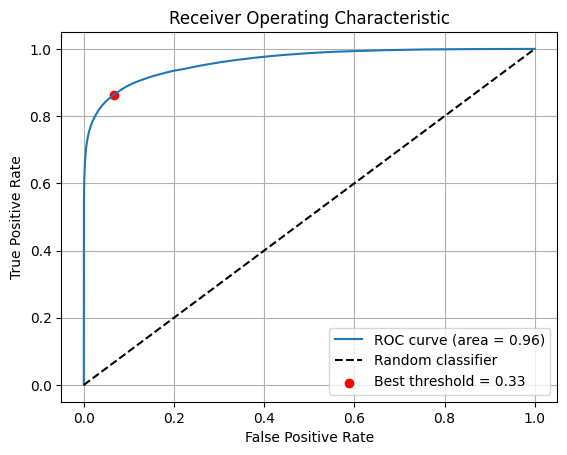

In [ ]:
y_pred_prob = model.predict(X).ravel()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
roc_auc = auc(fpr, tpr)

import numpy as np

j_scores = tpr - fpr
best_index = np.argmax(j_scores)
best_threshold = thresholds[best_index]

print(f"Best threshold: {best_threshold:.4f}")


import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier")
plt.scatter(fpr[best_index], tpr[best_index], color='red', label=f"Best threshold = {best_threshold:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()


## Export

Save model in TensorFlow format

In [ ]:
model.export("url_model_tf")

Saved artifact at 'url_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136407921141968: TensorSpec(shape=(1, 16), dtype=tf.float32, name=None)
  136407921135056: TensorSpec(shape=(1, 16), dtype=tf.float32, name=None)
  136415318494288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136407921139472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136407921141584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136407921140624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136407921195920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136407921195728: TensorSpec(shape=(), dtype=tf.resource, name=None)


Convert to TensorFlow.js format

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model url_model_tf ./tfjs_url_model

2025-05-01 20:59:02.676821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746133142.766614   26910 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746133142.786384   26910 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-01 20:59:11.348737: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1746133151.449528   26910 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [ ]:
# !rm -rf url_model_tf tfjs_url_model model